In [3]:
import requests
import time
from datetime import datetime
import csv
import os
import matplotlib.pyplot as plt

API_URL = "https://api.wheretheiss.at/v1/satellites/25544"
CSV_PATH = "iss_track.csv"

print("Collect ISS data here:", os.path.abspath(CSV_PATH))

Matplotlib is building the font cache; this may take a moment.


Collect ISS data here: /Users/adriennewang/Downloads/GitHub/ITMGT45/anaconda_projects/fbd0252b-d628-4240-9da6-874c933e5ac0/iss_track.csv


In [4]:
def fetch_iss_once():
    try:
        r = requests.get(API_URL, timeout=10)
        r.raise_for_status()
        data = r.json()
        ts = int(data["timestamp"])
        return {
            "unix_timestamp": ts,
            "iso_time": datetime.utcfromtimestamp(ts).isoformat() + "Z",
            "latitude": float(data["latitude"]),
            "longitude": float(data["longitude"]),
        }
        
    except Exception as e:
        print("Fetch error:", e)
        return None

In [5]:
target_points = 110
interval_seconds = 10

fieldnames = ["unix_timestamp", "iso_time", "latitude", "longitude"]

file_exists = os.path.exists(CSV_PATH)

if not file_exists:
    with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()

existing = 0
with open(CSV_PATH, "r", encoding="utf-8") as f:
    existing = sum(1 for _ in f) - 1
existing = max(existing, 0)

to_collect = max(target_points - existing, 0)
print(f"Already have {existing} points. Collecting {to_collect} more...")

collected = 0
while collected < to_collect:
    dp = fetch_iss_once()
    
    if dp:
        with open(CSV_PATH, "a", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writerow(dp)
        collected += 1
        have = existing + collected
        print(f"[{have}] {dp['iso_time']} lat={dp['latitude']:.4f}, lon={dp['longitude']:.4f}")

    if collected < to_collect:
        time.sleep(interval_seconds)

print("Done collecting.")


Already have 0 points. Collecting 110 more...


/var/folders/l0/r3lj1mqj5dzd8xrg4zw9y07c0000gn/T/ipykernel_74058/721393208.py:9: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "iso_time": datetime.utcfromtimestamp(ts).isoformat() + "Z",


[1] 2025-09-14T12:42:13Z lat=-51.7697, lon=-47.9568
[2] 2025-09-14T12:42:24Z lat=-51.7439, lon=-46.8617
[3] 2025-09-14T12:42:36Z lat=-51.7031, lon=-45.6688
[4] 2025-09-14T12:42:47Z lat=-51.6542, lon=-44.5776
[5] 2025-09-14T12:42:58Z lat=-51.5943, lon=-43.4890
[6] 2025-09-14T12:43:09Z lat=-51.5235, lon=-42.4037
[7] 2025-09-14T12:43:21Z lat=-51.4339, lon=-41.2240
[8] 2025-09-14T12:43:32Z lat=-51.3404, lon=-40.1472
[9] 2025-09-14T12:43:43Z lat=-51.2363, lon=-39.0751
[10] 2025-09-14T12:43:54Z lat=-51.1216, lon=-38.0083
[11] 2025-09-14T12:44:05Z lat=-50.9963, lon=-36.9472
[12] 2025-09-14T12:44:17Z lat=-50.8478, lon=-35.7967
[13] 2025-09-14T12:44:28Z lat=-50.7008, lon=-34.7489
[14] 2025-09-14T12:44:39Z lat=-50.5437, lon=-33.7082
[15] 2025-09-14T12:44:50Z lat=-50.3765, lon=-32.6749
[16] 2025-09-14T12:45:02Z lat=-50.1828, lon=-31.5565
[17] 2025-09-14T12:45:14Z lat=-49.9775, lon=-30.4478
[18] 2025-09-14T12:45:25Z lat=-49.7791, lon=-29.4403
[19] 2025-09-14T12:45:37Z lat=-49.5520, lon=-28.3512
[2

In [6]:
lats, lons, times = [], [], []

with open(CSV_PATH, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        lats.append(float(row["latitude"]))
        lons.append(float(row["longitude"]))
        times.append(row["iso_time"])

print(f"Loaded {len(lats)} points.")
print("First 3 rows:")
for i in range(min(3, len(lats))):
    print(times[i], lats[i], lons[i])

Loaded 110 points.
First 3 rows:
2025-09-14T12:42:13Z -51.769709305164 -47.956807712783
2025-09-14T12:42:24Z -51.743864881969 -46.861674779026
2025-09-14T12:42:36Z -51.703071824006 -45.668788224061


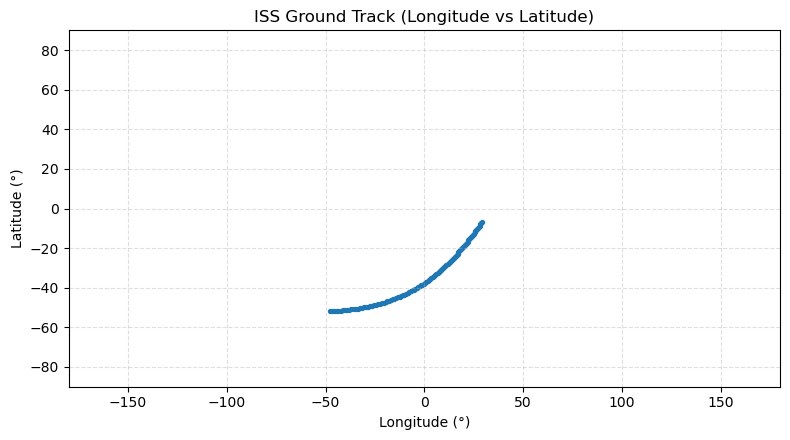

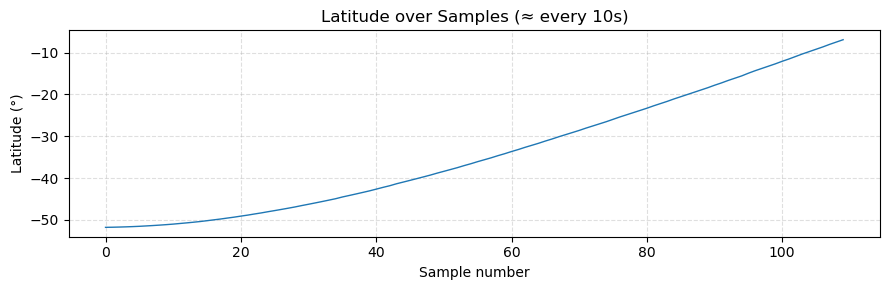

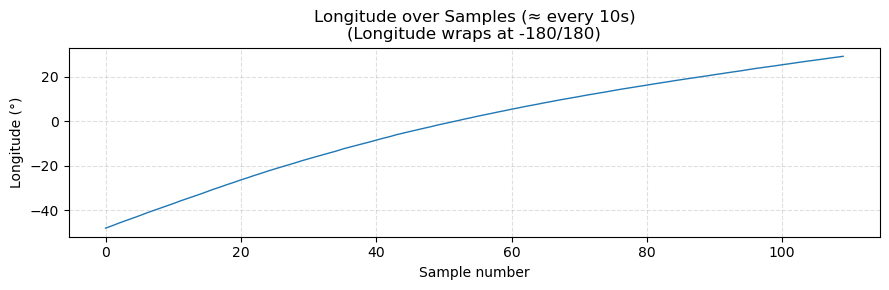

In [7]:
# 1) Path plot (longitude vs latitude)
plt.figure(figsize=(8, 4.5))
plt.scatter(lons, lats, s=8)
plt.title("ISS Ground Track (Longitude vs Latitude)")
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("iss_path.png", dpi=180)
plt.show()

# 2) Latitude over time
plt.figure(figsize=(9, 3))
plt.plot(lats, linewidth=1)
plt.title("Latitude over Samples (≈ every 10s)")
plt.xlabel("Sample number")
plt.ylabel("Latitude (°)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("iss_latitude_over_time.png", dpi=180)
plt.show()

# 3) Longitude over time
plt.figure(figsize=(9, 3))
plt.plot(lons, linewidth=1)
plt.title("Longitude over Samples (≈ every 10s)\n(Longitude wraps at -180/180)")
plt.xlabel("Sample number")
plt.ylabel("Longitude (°)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("iss_longitude_over_time.png", dpi=180)
plt.show()